In [1]:
import pandas as pd
df=pd.read_csv('try.csv')

In [2]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nandiniupadhyay/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nandiniupadhyay/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nandiniupadhyay/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
titles=df['title'].tolist()
cleaned_titles=[]
# Define the lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

# Preprocessing function
for text in titles:
    # Lowercase the text
    text = text.lower()
    
    # Remove punctuation and special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
      
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stopwords and lemmatize each word
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    # Join tokens back into a single string
    preprocessed_text = " ".join(tokens)
    
    cleaned_titles.append(preprocessed_text)

# Add the cleaned titles back to the DataFrame
df['cleaned_title'] = cleaned_titles

# Display the DataFrame
df.head()

,Unnamed: 0,ticker,date,time,title,cleaned_title
0,0,AMZN,Feb-19-25,07:56AM,Amazon joins forces with Memorial Sloan Ketter...,amazon join force memorial sloan kettering aip...
1,1,AMZN,Feb-19-25,06:38AM,Amazon $100B AI Investment Stumbles Amid Suppl...,amazon b ai investment stumble amid supply hurdle
2,2,AMZN,Feb-19-25,06:14AM,Can Oracle (ORCL) Capitalize on the $500B AI S...,oracle orcl capitalize b ai stargate bonanza
3,3,AMZN,Feb-19-25,05:30AM,Better Artificial Intelligence Stock: Rigetti ...,better artificial intelligence stock rigetti c...
4,4,AMZN,Feb-19-25,05:00AM,"Amazon, Disney, Starbucks and 5 other big comp...",amazon disney starbucks big company help pay e...


In [4]:
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import wordnet
nltk.download('sentiwordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package sentiwordnet to
[nltk_data]     /Users/nandiniupadhyay/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/nandiniupadhyay/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [5]:
def get_wordnet_pos(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
lemmatizer = WordNetLemmatizer()
X_tfidf = vectorizer.fit_transform(df['title'])
tfidf_feature_names = (vectorizer.get_feature_names_out())

def calculate_weighted_sentiment_score(text, tfidf_vector):
    tokens = word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)
    weighted_score = 0

    for idx, (word, tag) in enumerate(pos_tags):
        # Get WordNet POS tag and lemmatize the word
        wn_tag = get_wordnet_pos(tag)
        if wn_tag:  # Only proceed if POS tag is recognized
            lemma = lemmatizer.lemmatize(word, pos=wn_tag)

            # Get SentiWordNet scores
            synsets = list(swn.senti_synsets(lemma, wn_tag))
            if synsets:
                # Take the first synset as the representative score
                synset = synsets[0]
                sentiment_score = synset.pos_score() - synset.neg_score()
                
                if word in tfidf_feature_names:
                    
                    tfidf_index = tfidf_feature_names.tolist().index(word)
                    tfidf_value = tfidf_vector[tfidf_index]

                    # Multiply sentiment score by TF-IDF weight
                    weighted_score += sentiment_score * tfidf_value 

    return weighted_score

#Apply the weighted sentiment score calculation for each title
weighted_scores = []
for i, title in enumerate(df['title']):
    tfidf_vector = X_tfidf[i].toarray().flatten()
    weighted_score = calculate_weighted_sentiment_score(title, tfidf_vector)
    weighted_scores.append(weighted_score)

# Add weighted scores to DataFrame
df['weighted_sentiment_score'] = weighted_scores

#Assign labels based on the weighted sentiment score
def assign_sentiment_label(score):
    if score >= 0:
        return 'positive'
    else:
        return 'negative'
    
df['sentiment_label'] = df['weighted_sentiment_score'].apply(assign_sentiment_label)

print(df[['title', 'weighted_sentiment_score', 'sentiment_label']])

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
lemmatizer = WordNetLemmatizer()

X_tfidf = vectorizer.fit_transform(df['title'])
# tfidf_feature_names = vectorizer.get_feature_names_out()
tfidf_feature_names = (vectorizer.get_feature_names_out())[:500] 



In [15]:
def calculate_weighted_sentiment_score(text, tfidf_vector):
    tokens = word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)
    weighted_score = 0

    for idx, (word, tag) in enumerate(pos_tags):
        # Get WordNet POS tag and lemmatize the word
        wn_tag = get_wordnet_pos(tag)
        if wn_tag:  # Only proceed if POS tag is recognized
            lemma = lemmatizer.lemmatize(word, pos=wn_tag)

            # Get SentiWordNet scores
            synsets = list(swn.senti_synsets(lemma, wn_tag))
            if synsets:
                # Take the first synset as the representative score
                synset = synsets[0]
                sentiment_score = synset.pos_score() - synset.neg_score()
                
                if word in tfidf_feature_names:
                    
                    tfidf_index = tfidf_feature_names.tolist().index(word)
                    tfidf_value = tfidf_vector[tfidf_index]

                    # Multiply sentiment score by TF-IDF weight
                    weighted_score += sentiment_score * tfidf_value 

    return weighted_score

# Step 3: Apply the weighted sentiment score calculation for each title
weighted_scores = []
for i, title in enumerate(df['title']):
    tfidf_vector = X_tfidf[i].toarray().flatten()
    weighted_score = calculate_weighted_sentiment_score(title, tfidf_vector)
    weighted_scores.append(weighted_score)

# Add weighted scores to DataFrame
df['weighted_sentiment_score'] = weighted_scores

# Step 4: Assign labels based on the weighted sentiment score
def assign_sentiment_label(score):
    if score >= 0:
        return 'positive'
    else:
        return 'negative'
    

df['sentiment_label'] = df['weighted_sentiment_score'].apply(assign_sentiment_label)

# Display the DataFrame with scores and labels
print(df[['title', 'weighted_sentiment_score', 'sentiment_label']])

                                                  title  \
0     Amazon joins forces with Memorial Sloan Ketter...   
1     Amazon $100B AI Investment Stumbles Amid Suppl...   
2     Can Oracle (ORCL) Capitalize on the $500B AI S...   
3     Better Artificial Intelligence Stock: Rigetti ...   
4     Amazon, Disney, Starbucks and 5 other big comp...   
...                                                 ...   
2995  Trump has 'constructive call' with Vietnam, li...   
2996  Top Stock Movers Now: Boeing, DuPont, Tesla, a...   
2997  Trump Says Vietnam Wants to Cut Its Tariffs to...   
2998  Jim Cramer on Nike (NKE): "They've Lost Their ...   
2999  Wall Street hunts for cheap tariff-proof stock...   

      weighted_sentiment_score sentiment_label  
0                          0.0        positive  
1                          0.0        positive  
2                          0.0        positive  
3                          0.0        positive  
4                          0.0        positive

In [16]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
# Initialize VADER Sentiment Intensity Analyzer
sia = SentimentIntensityAnalyzer()

# Function to assign sentiment labels
def assign_sentiment(text):
    score = sia.polarity_scores(text)['compound']
    if score >=0:
        return 'positive'
    else:
        return 'negative'

# Apply the function to the 'cleaned_title' column
df['label'] = df['cleaned_title'].apply(assign_sentiment)

# Display the DataFrame with sentiment labels
print(df[['cleaned_title', 'label']])


                                          cleaned_title     label
0     amazon join force memorial sloan kettering aip...  positive
1     amazon b ai investment stumble amid supply hurdle  positive
2          oracle orcl capitalize b ai stargate bonanza  positive
3     better artificial intelligence stock rigetti c...  positive
4     amazon disney starbucks big company help pay e...  positive
...                                                 ...       ...
2995  trump constructive call vietnam lifting nike o...  positive
2996                top stock mover boeing dupont tesla  positive
2997             trump say vietnam want cut tariff zero  negative
2998       jim cramer nike nke theyve lost edge running  negative
2999   wall street hunt cheap tariffproof stock carnage  positive

[3000 rows x 2 columns]


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/nandiniupadhyay/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [17]:
from sklearn.metrics import accuracy_score, recall_score,precision_score, f1_score
print("Accuracy:", accuracy_score(df['label'], df['sentiment_label']))
precision = precision_score(df['label'], df['sentiment_label'], average='binary',pos_label='positive')
recall = recall_score(df['label'], df['sentiment_label'], average='binary',pos_label='positive')
f1 = f1_score(df['label'], df['sentiment_label'], average='binary',pos_label='positive')
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

Accuracy: 0.8153333333333334
Precision: 0.82
Recall: 1.00
F1-Score: 0.90


In [10]:
from sklearn.metrics import classification_report
print("Classification Report:\n", classification_report(df['label'], df['sentiment_label']))

Classification Report:
               precision    recall  f1-score   support

    negative       0.39      0.18      0.24       551
    positive       0.84      0.94      0.88      2449

    accuracy                           0.80      3000
   macro avg       0.61      0.56      0.56      3000
weighted avg       0.75      0.80      0.77      3000



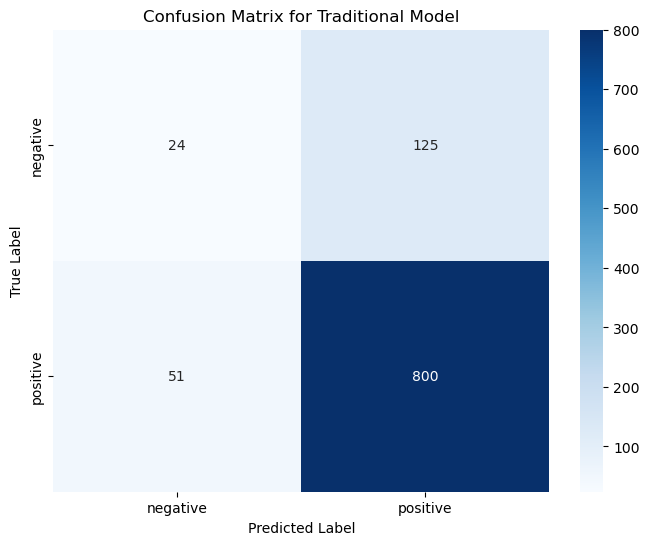

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming y_pred_cnn_labels contains the predicted labels from the CNN model
# and y_test contains the true labels


# Generate the confusion matrix
conf_matrix = confusion_matrix(df['label'], df['sentiment_label'])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'positive'], yticklabels=['negative', 'positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Traditional Model')
plt.show()